In [155]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML


In [156]:
BATCH_SIZE = 2
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [157]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "suduko",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 25 files belonging to 2 classes.


In [158]:

class_names = dataset.class_names
class_names


['class1', 'class2']

In [159]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(2, 256, 256, 3)
[1 0]


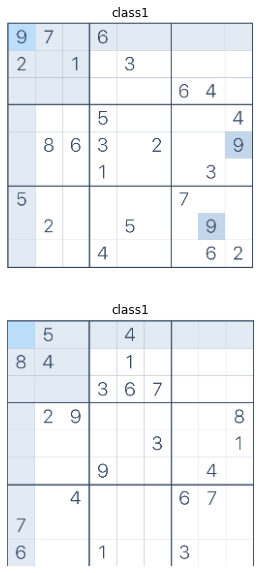

In [160]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(batch_size):
        ax = plt.subplot(2, batch_size//2, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [161]:
len(dataset)

13

In [162]:
train_size = 0.8
len(dataset)*train_size

10.4

In [163]:
test_ds = dataset.skip(10)
len(test_ds)

3

In [164]:
val_size=0.1
len(dataset)*val_size


1.3

In [165]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [166]:
test_ds = test_ds.skip(1)
len(test_ds)

2

In [167]:
batch_size = 2

In [168]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [169]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [170]:
len(train_ds), len(val_ds), len(test_ds)

(10, 1, 2)

In [171]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [172]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [173]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [174]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [175]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [178]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (2, 256, 256, 3)          0         
                                                                 
 conv2d_15 (Conv2D)          (2, 254, 254, 32)         896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (2, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (2, 125, 125, 64)         18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (2, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (2, 60, 60, 64)         

In [179]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [180]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
10/10 [==============================] - 3s 173ms/step - loss: 0.9456 - accuracy: 0.3684 - val_loss: 0.6416 - val_accuracy: 1.0000
Epoch 2/50
10/10 [==============================] - 1s 130ms/step - loss: 0.8076 - accuracy: 0.5789 - val_loss: 1.1067 - val_accuracy: 0.0000e+00
Epoch 3/50
10/10 [==============================] - 1s 142ms/step - loss: 0.8348 - accuracy: 0.4737 - val_loss: 0.9943 - val_accuracy: 0.0000e+00
Epoch 4/50
10/10 [==============================] - 1s 141ms/step - loss: 0.8315 - accuracy: 0.4737 - val_loss: 1.0492 - val_accuracy: 0.0000e+00
Epoch 5/50
10/10 [==============================] - 1s 138ms/step - loss: 0.7804 - accuracy: 0.4737 - val_loss: 0.7500 - val_accuracy: 0.0000e+00
Epoch 6/50
10/10 [==============================] - 1s 136ms/step - loss: 0.7199 - accuracy: 0.4211 - val_loss: 0.6341 - val_accuracy: 1.0000
Epoch 7/50
10/10 [==============================] - 1s 128ms/step - loss: 0.7411 - accuracy: 0.3684 - val_loss: 0.8030 - val_accurac

In [182]:
scores = model.evaluate(test_ds, verbose=0)
scores

[0.6949946880340576, 0.5]

In [183]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 10}

In [184]:
history.history['loss'][:5]

[0.9456301331520081,
 0.8075591325759888,
 0.8347709774971008,
 0.8315442800521851,
 0.7804027795791626]

In [185]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

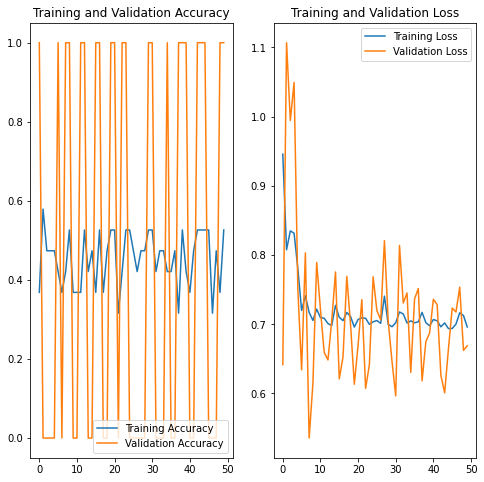

In [186]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: class1
1/1 [==============================] - 0s 195ms/step
predicted label: class2


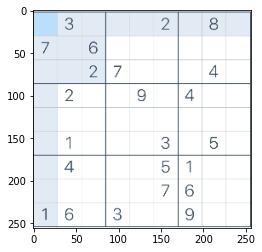

In [188]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [176]:
len

<function len(obj, /)>